In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, random_split

from src.methods.rise_model import RISE
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

from src.common.utils import *
from src.common.evaluation import CausalMetric, auc, gkern

import zipfile
from pathlib import Path

In [11]:
# --- SET SEED FOR REPRODUCIBILITY ---
SEED = 42  # фиксируем seed для полной воспроизводимости
torch.manual_seed(SEED)  # фиксируем seed для PyTorch
random.seed(SEED)        # фиксируем seed для Python random
np.random.seed(SEED)     # фиксируем seed для NumPy
torch.backends.cudnn.deterministic = True  # гарантирует детерминированность на GPU
torch.backends.cudnn.benchmark = False     # отключаем autotuner, чтобы не влиял на детерминированность

# --- CONFIGURATION ---
output = 'data_full.zip'
unzip_dir = 'unzipped_data_full'

if not os.path.exists(unzip_dir):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)

data_dir = 'unzipped_data_full/data_full'
batch_size = 8                 # количество изображений в одном батче
num_epochs = 20                # сколько раз модель проходит весь датасет
val_split = 0.2                # доля валидационных данных (20%)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # автоматический выбор CUDA или CPU
device

device(type='cuda')

In [12]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [13]:
# трансформации для валидационной выборки (без аугментаций)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --- DATASET ---
full_dataset = datasets.ImageFolder(data_dir)   # читаем датасет: каждая папка = один класс
class_names = full_dataset.classes              # сохраняем список классов

val_size = int(len(full_dataset) * val_split)   # размер валидационной выборки
train_size = len(full_dataset) - val_size       # размер тренировочной выборки

# фиксированный random_split с генератором (для стабильного train/val деления)
generator = torch.Generator().manual_seed(SEED)
_, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

# применяем трансформации
val_dataset.dataset.transform = val_transform

In [14]:
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))

model.load_state_dict(torch.load('best_model.pth'))
model = model.eval()
model = model.to(device)

for p in model.parameters():
    p.requires_grad = False

In [15]:
explainer = RISE(model, input_size=(224, 224), gpu_batch=64)

# maskspath = 'masks.npy'
# if not os.path.exists(maskspath):
#     explainer.generate_masks(N=500, s=8, p1=0.1, savepath=maskspath)
# else:
#     explainer.load_masks(maskspath, p1=0.1)

maskspath = 'masks.npy'
explainer.generate_masks(N=600, s=8, p1=0.3, savepath=maskspath)
#explainer.generate_gaussian_masks(N=600, s=8, savepath=maskspath)

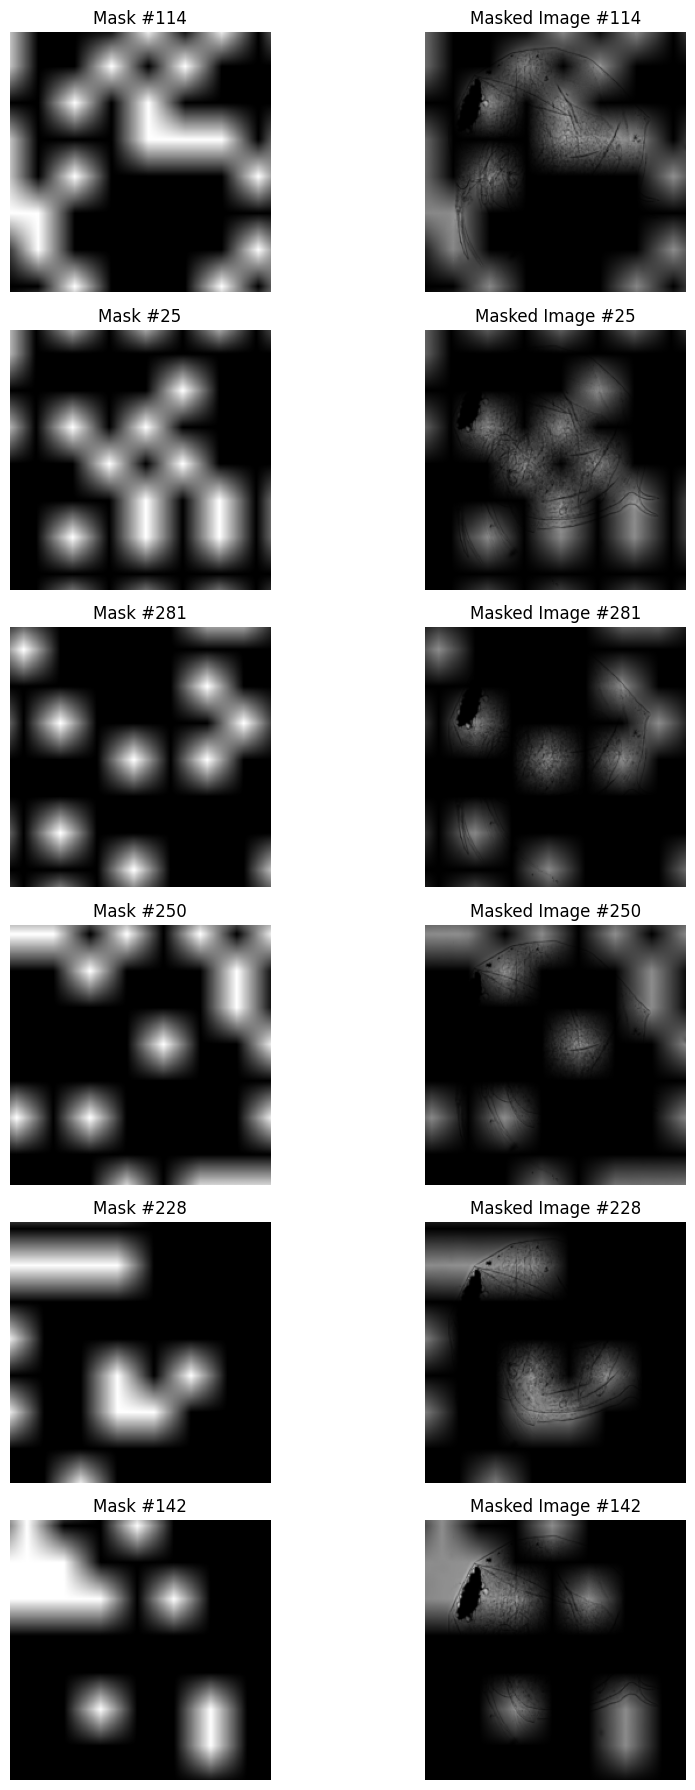

In [16]:
sample_img, label = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)
visualize_masks_and_masked_images(sample_img, explainer.masks, num=6)

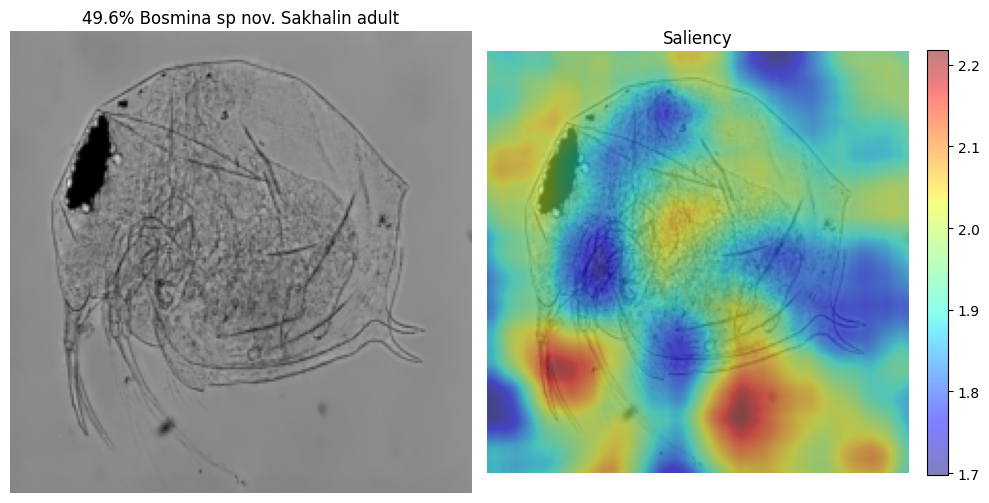

In [17]:
def explain_and_plot(img, top_k=1):
    saliency = explainer(img.cuda()).cpu().numpy()

    output = model(img)
    probs = torch.softmax(output, dim=1)
    p, c = torch.topk(probs, k=top_k)
    p, c = p[0], c[0]

    plt.figure(figsize=(10, 5 * top_k))
    for i in range(top_k):
        plt.subplot(top_k, 2, 2 * i + 1)
        plt.axis('off')
        class_name = class_names[c[i]]
        title = f'{100 * p[i]:.1f}% {class_name}'
        plt.title(title)
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2 * i + 2)
        plt.axis('off')
        plt.title('Saliency')
        tensor_imshow(img[0])
        plt.imshow(saliency[c[i]], cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

sample_img, label = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device) 
explain_and_plot(sample_img)

In [18]:
sample_img, label = val_dataset[6]
sample_img = sample_img.unsqueeze(0).to(device) 
explain_and_plot(sample_img, class_names=class_names)

TypeError: explain_and_plot() got an unexpected keyword argument 'class_names'

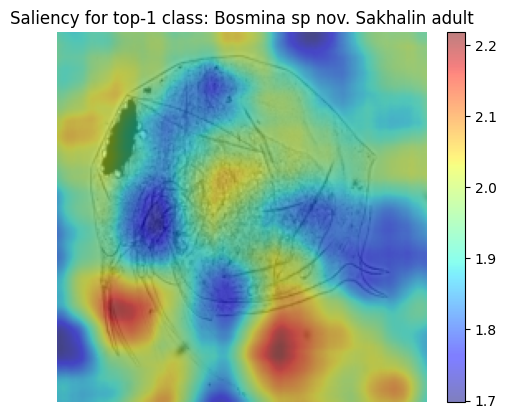

In [ ]:
sample_img, _ = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(sample_img)
    probs = torch.softmax(output, dim=1)
    top1_class = probs.argmax(dim=1).item()

saliency_all = explainer(sample_img).cpu().numpy()
saliency = saliency_all[top1_class]

plt.axis('off')
plt.title(f'Saliency for top-1 class: {class_names[top1_class]}')
tensor_imshow(sample_img[0].cpu())
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [ ]:
import random

def explain_multiple_rise(val_dataset, explainer, class_names, n_samples=5):
    # indices = random.sample(range(len(val_dataset)), n_samples)
    indices = [0, 4, 6, 8, 9]

    plt.figure(figsize=(8, 4 * n_samples))

    for i, idx in enumerate(indices):
        img, label = val_dataset[idx]
        img_input = img.unsqueeze(0).to(device)

        saliency = explainer(img_input.cuda()).cpu().numpy()

        with torch.no_grad():
            output = model(img_input)
            probs = torch.softmax(output, dim=1)
            conf, class_idx = torch.max(probs, dim=1)

        class_name = class_names[class_idx.item()]
        title = f'{100 * conf.item():.1f}% {class_name}'

        plt.subplot(n_samples, 2, 2 * i + 1)
        plt.axis('off')
        plt.title(title)
        tensor_imshow(img.cpu())

        plt.subplot(n_samples, 2, 2 * i + 2)
        plt.axis('off')
        plt.title('RISE Saliency')
        tensor_imshow(img.cpu())
        plt.imshow(saliency[class_idx.item()], cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

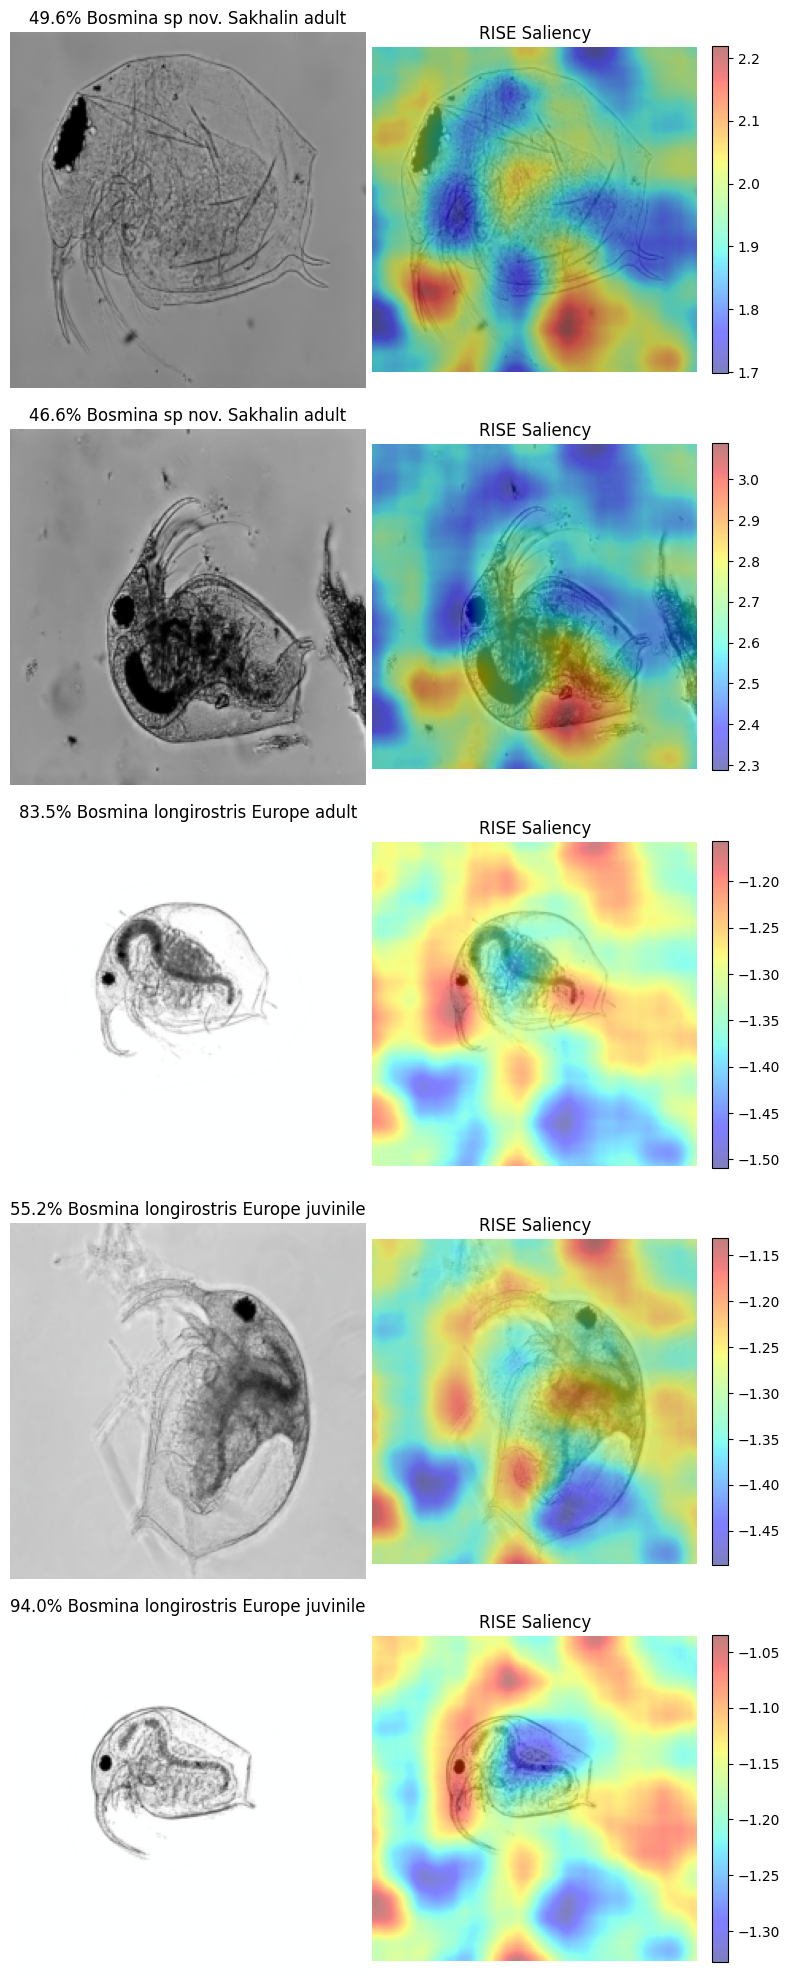

In [ ]:
explain_multiple_rise(val_dataset, explainer, class_names, n_samples=5)

In [ ]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern.to(x.device), padding=klen//2)

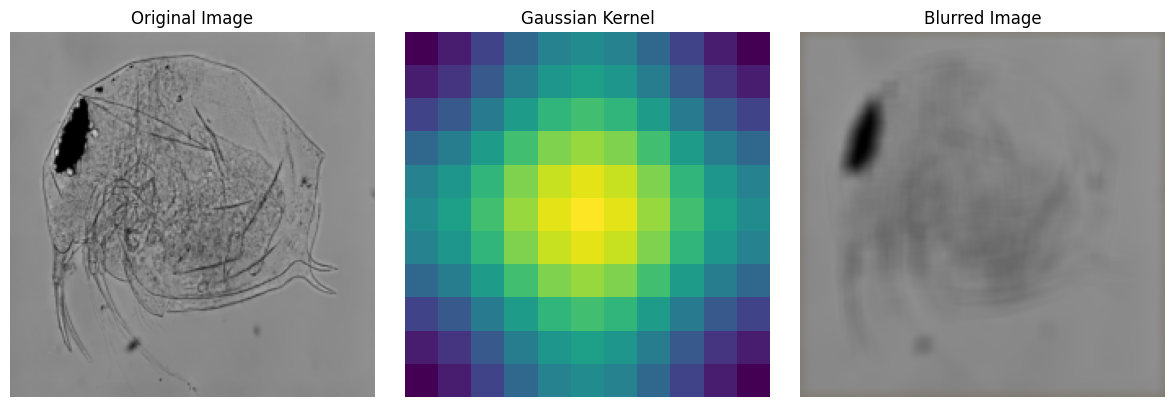

In [ ]:
def plot_blur(img):
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.axis('off')
    plt.title("Original Image")
    tensor_imshow(img[0])

    plt.subplot(132)
    plt.axis('off')
    plt.title("Gaussian Kernel")
    plt.imshow(kern[0, 0])

    plt.subplot(133)
    plt.axis('off')
    plt.title("Blurred Image")
    tensor_imshow(blur(img)[0])

    plt.tight_layout()
    plt.show()

sample_img, label = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)
plot_blur(sample_img)

In [ ]:
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

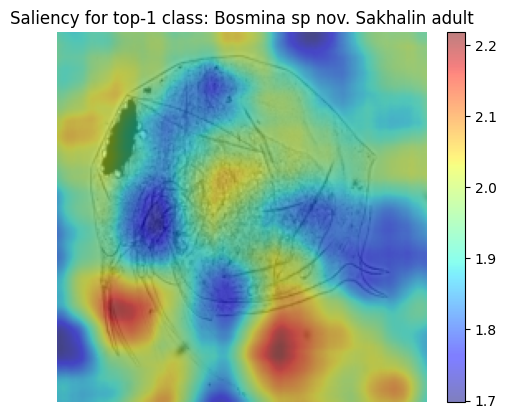

In [ ]:
sample_img, _ = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(sample_img)
    probs = torch.softmax(output, dim=1)
    top1_class = probs.argmax(dim=1).item()

saliency_all = explainer(sample_img).cpu().numpy()
saliency = saliency_all[top1_class]

plt.axis('off')
plt.title(f'Saliency for top-1 class: {class_names[top1_class]}')
tensor_imshow(sample_img[0].cpu())
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


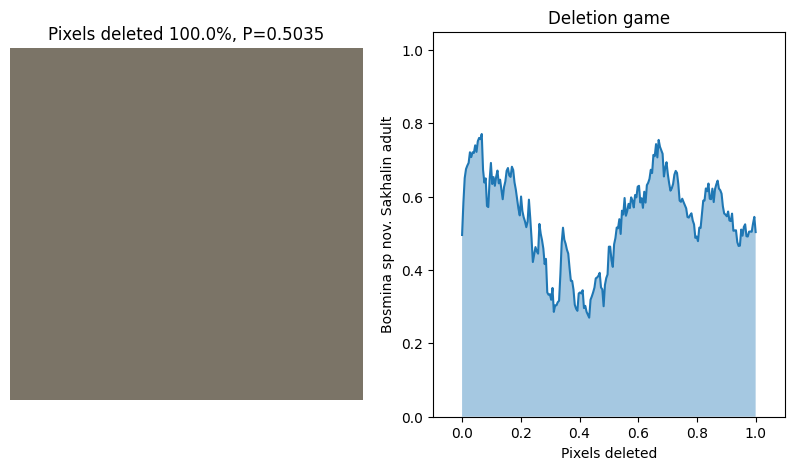

In [ ]:
h = deletion.single_run(sample_img, saliency, class_names=class_names, device=device, verbose=1)

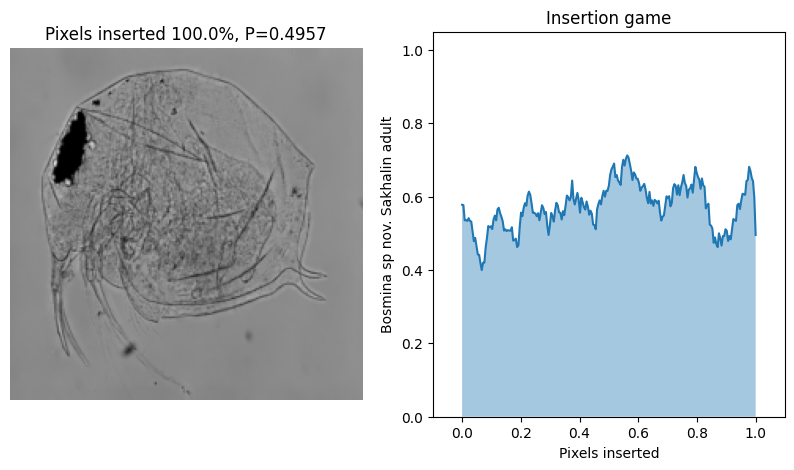

In [ ]:
h = insertion.single_run(sample_img, saliency, class_names=class_names, device=device, verbose=1)

In [ ]:
images = []
explanations = []

for i in range(len(val_dataset)):
    img, _ = val_dataset[i]
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)
        top1_class = probs.argmax(dim=1).item()

    saliency_all = explainer(img).cpu().numpy()
    saliency = saliency_all[top1_class]

    images.append(img.squeeze(0).cpu())
    explanations.append(saliency)

images_tensor = torch.stack(images).to(device)
saliency_np = np.stack(explanations)

insertion = CausalMetric(model, 'ins', step=224*8, substrate_fn=blur)
deletion = CausalMetric(model, 'del', step=224*8, substrate_fn=torch.zeros_like)

h_del = deletion.evaluate(images_tensor, saliency_np, device=device, batch_size=1)
h_ins = insertion.evaluate(images_tensor, saliency_np, device=device, batch_size=1)

print('Deletion AUC:', auc(h_del.mean(1)))
print('Insertion AUC:', auc(h_ins.mean(1)))

Deleting  pixels: 100%|██████████| 29/29 [00:08<00:00,  3.33it/s]


AUC: 0.31660732778980455


Inserting pixels: 100%|██████████| 29/29 [00:08<00:00,  3.31it/s]

AUC: 0.5289850128007171
Deletion AUC: 0.31660732778980455
Insertion AUC: 0.5289850128007171
